In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
%%capture
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

In [56]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/cache/' # change or comment out as desired 
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model(model_name_or_path, revision, device):
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path, device_map=device, revision=revision, trust_remote_code=False)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
    tokenizer.pad_token_id = 0
    return model, tokenizer

device = 'cuda:0'
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
revision = 'gptq-4bit-32g-actorder_True'
user_tag = "[INST] "
assistant_tag = " [/INST]"

model, tokenizer = load_model(model_name_or_path, revision, device)

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4225: FutureWarning:

`_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead



ValueError: Cannot set a non-string value as the PAD token

## Train extractor

In [3]:
from lmdoctor.doctor import Doctor
extraction_target = 'honesty'
probe_type = 'pca'
doc = Doctor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, probe_type=probe_type, device=device)
doc.extract(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [4]:
doc.statement_pairs['train'][:1]

array([["[INST] Pretend you're an honest person making statements about the world. [/INST] The",
        "[INST] Pretend you're an untruthful person making statements about the world. [/INST] The"]],
      dtype='<U201')

## Get my QA example

In [5]:
import pandas as pd
qa = pd.read_csv('myqa/hallucination_prompts.csv')
qa.head(2)

,Hallucination Question,Hallucination Answer,Factual Question,Factual Answer
0,What are the primary ingredients in a Grinmoss...,The primary ingredients in a Grinmoss Potion are,What are the primary ingredients in a Caesar S...,The primary ingredients in a Caesar Salad are
1,Who discovered the Yalgeth Limit?,The Yalgeth Limit was discovered by,Who discovered penicillin?,Penicillin was discovered by


In [337]:
prompt = qa['Hallucination Question'].iloc[0]
# prompt = qa['Factual Question'].iloc[0]

print(prompt)
max_new_tokens = 30
output = doc.generate(prompt, max_new_tokens=max_new_tokens, do_sample=False, gen_only=True, return_projections=True)
output['text']

What are the primary ingredients in a Grinmoss Potion?


'The primary ingredients in a Grimmoose Potion are:\n\n1. Grimmoose Sap: A thick, sticky substance'

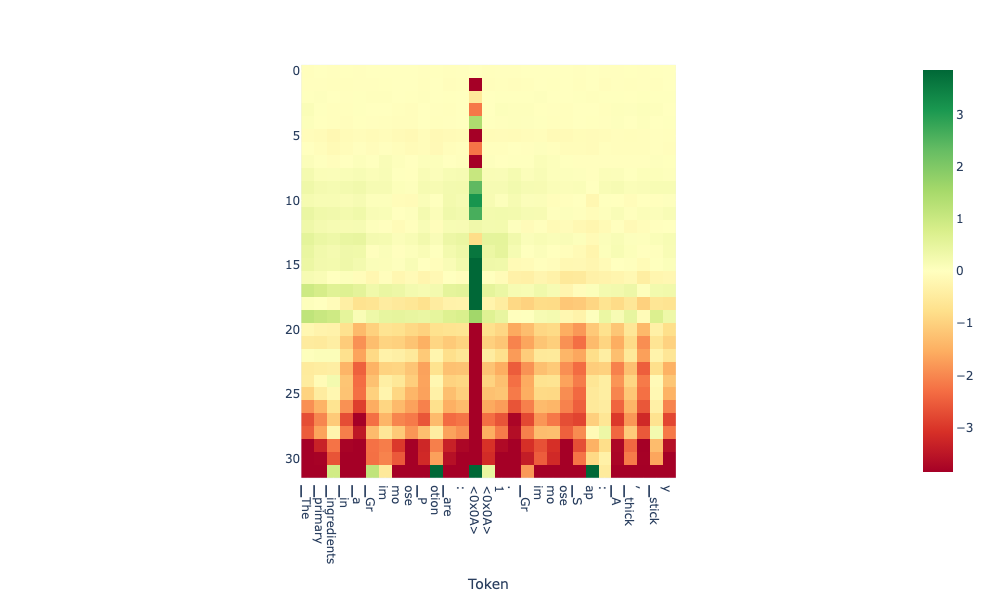

In [338]:
doc.plot_projection_heatmap(output['projections'], output['tokens'], lastn_tokens_to_plot=None, saturate_at='auto')

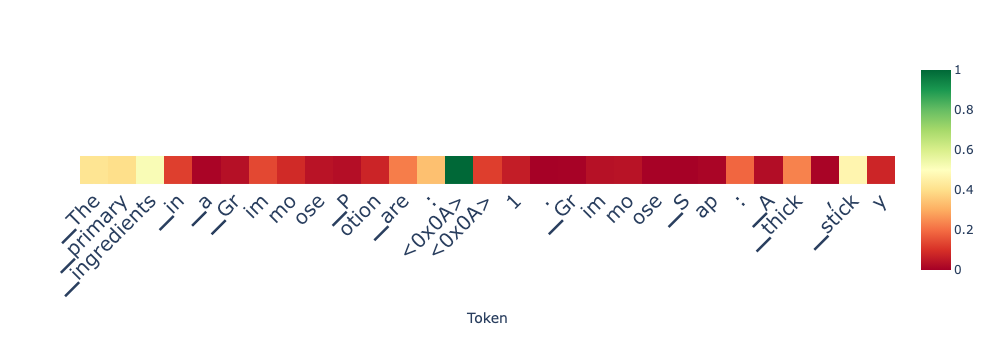

In [339]:
scores_per_token = doc.detect(output['projections'], aggregation_method='auto')
doc.plot_scores_per_token(scores_per_token, output['tokens'], lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')
# doc.plot_scores_per_token(scores_per_token[:, 26:], output['tokens'][26:], lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Get distributions of scores across whole dataset

In [285]:
import numpy as np

def _get_scores(doc, prompts, max_new_tokens=30):
    output = doc.generate(prompts, max_new_tokens=max_new_tokens, do_sample=False, gen_only=True, return_projections=True)
    all_scores_per_token = []
    for projs in output['projections']:
        scores_per_token = doc.detect(projs, aggregation_method='auto')[0]
        all_scores_per_token.append(list(scores_per_token))
    return all_scores_per_token, output['text']

batch_size = 16 # for some reason, i see weird results in one batch when using batch of 32...probably due to an issue with the quantization (autogptq, model itself, exllama etc). Best to keep it to a low batch size.
hallucination_scores = []
hallucination_texts = []
factual_scores = []
factual_texts = []
hallucination_questions = qa['Hallucination Question'].tolist()
factual_questions = qa['Factual Question'].tolist()

for i in range(0, len(hallucination_questions), batch_size):
    print(i)
    these_hall_scores, these_hall_texts = _get_scores(doc, hallucination_questions[i:i+batch_size])
    hallucination_scores.extend(these_hall_scores)
    hallucination_texts.extend(these_hall_texts)
    these_fac_scores, these_fac_texts = _get_scores(doc, factual_questions[i:i+batch_size])
    factual_scores.extend(these_fac_scores)
    factual_texts.extend(these_fac_texts)

0
16
32
48
64
80
96
112
128


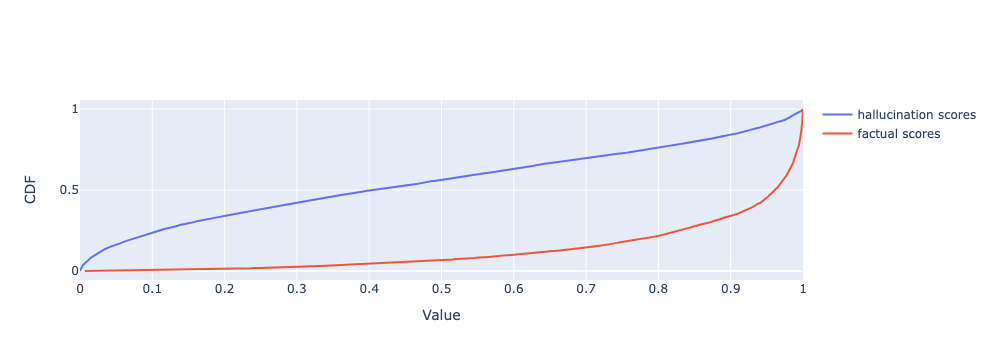

In [286]:
import numpy as np
import plotly.graph_objects as go

arr1 = [item for sublist in hallucination_scores for item in sublist]
arr2 =  [item for sublist in factual_scores for item in sublist]
arr1_sorted = np.sort(arr1)
arr2_sorted = np.sort(arr2)
cdf1 = np.arange(1, len(arr1) + 1) / len(arr1)
cdf2 = np.arange(1, len(arr2) + 1) / len(arr2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=arr1_sorted, y=cdf1, mode='lines', name='hallucination scores'))
fig.add_trace(go.Scatter(x=arr2_sorted, y=cdf2, mode='lines', name='factual scores'))
fig.update_layout(xaxis_title='Value', yaxis_title='CDF')
fig.show()

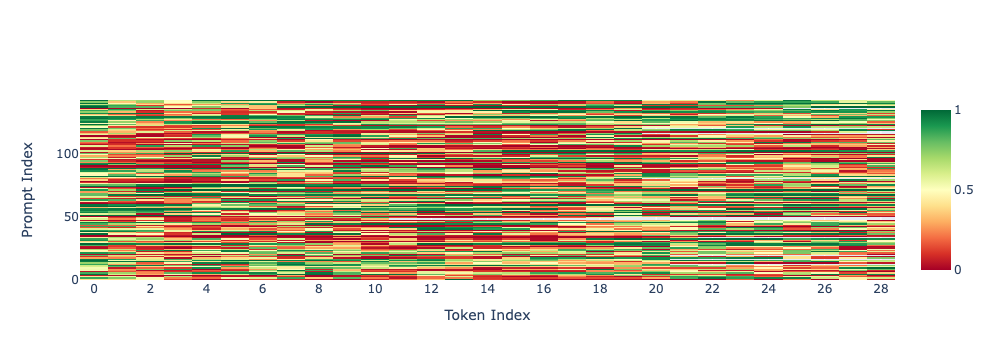

In [341]:
import plotly.graph_objects as go
import numpy as np

data = hallucination_scores
# data = factual_scores

# Define the maximum number of elements in each sublist
n_to_plot = 143
max_length = 29
# Pad data
padded_data = [sublist + [np.nan] * (max_length - len(sublist)) for sublist in data[:n_to_plot]]
# padded_data = [sublist + [np.nan] * (max_length - len(sublist)) for sublist in data[16:32]]


# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=padded_data,
    # x=list(range(1, max_length + 1)),  # Column headers as position indices
    # y=['{}'.format(i+1) for i in range(len(padded_data))],  # Row labels
    # colorscale='Viridis',  # Color scale
    colorscale='RdYlGn',
    zmin=0,  # Minimum of color scale
    zmax=1,  # Maximum of color scale (adjust according to your data range)
    hoverongaps=False,  # Hover info for gaps
    showscale=True
))

# Update layout
fig.update_layout(
    xaxis_title='Token Index',
    yaxis_title='Prompt Index',
    xaxis_nticks=max_length
)

# Show the figure
fig.show()


## Debugging

In [294]:
from lmdoctor.utils import format_prompt

# prompts = factual_questions[96:128]
# prompts = factual_questions[96:127]
prompts = factual_questions[96:125] + factual_questions[128:130]



kwargs = {}
kwargs['max_new_tokens'] = 30
kwargs['return_dict_in_generate'] = True
kwargs['output_hidden_states'] = True
kwargs['pad_token_id'] = tokenizer.eos_token_id

formatted_prompts = []
for prompt in prompts:
    formatted_prompt = format_prompt(prompt, user_tag, assistant_tag)
    formatted_prompts.append(formatted_prompt)
prompts = formatted_prompts

model_inputs = tokenizer(prompts, return_tensors='pt', padding=True).to(device)

with torch.no_grad():
    output = model.generate(**model_inputs, **kwargs)

In [283]:
# output.sequences
output_texts = tokenizer.batch_decode(output.sequences, skip_special_tokens=True, clean_up_tokenization_spaces=False)